# Align with Void Tracking
The void tracks from the FFTs seem to have a large degree of jumps. Let's try to align images in a way which minimizes the net motion of all voids.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from rtdefects.analysis import convert_to_per_particle, compile_void_tracks, compute_drift
from skimage.transform import AffineTransform, warp
from pathlib import Path
from tqdm import tqdm
import trackpy as tp
import pandas as pd
import numpy as np
import imageio

Configuration

In [2]:
run_directory = '../data/8bitTIFF-video26-575C/'

Determine location of keys files

In [3]:
run_directory = Path(run_directory)
out_directory = Path('output') / run_directory.name
defect_file = out_directory / 'defect-details.json'

## Determine the drift from defect movement
We are going to do a very conservative particle tracking and evaluate drift based on the average movement of all defects.

In [4]:
frame_data = pd.read_json(defect_file, lines=True)
print(f'Loaded data from {len(frame_data)} frames')

Loaded data from 969 frames


In [5]:
images = sorted((run_directory / 'masks/').glob('*tif'))
print(f'Found {len(images)} images')

Found 969 images


Do a check where we only allow small movements of voids and do not remember them for more than 3 frames

In [6]:
%%time
particles = pd.concat(list(convert_to_per_particle(frame_data, position_col='positions')))
initial_tracks = tp.link_df(particles, search_range=4, memory=4)
print(f'Found a total of {len(initial_tracks.particle.value_counts())} unique particles out of {frame_data["void_count"].sum()} total')

Frame 968: 11 trajectories present.
Found a total of 13413 unique particles out of 14536 total
CPU times: user 1.05 s, sys: 97.9 ms, total: 1.14 s
Wall time: 1.05 s


Compute the median drift between each frame

In [7]:
total_drift = compute_drift(initial_tracks)

Plot how the drift goes over time.

In [8]:
initial_tracks['radius'].describe()

count    14536.000000
mean        10.338094
std          5.897616
min          3.989423
25%          5.014627
50%          7.399277
75%         15.897737
max         22.046750
Name: radius, dtype: float64

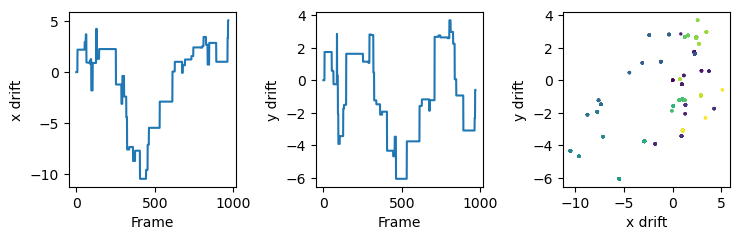

In [9]:
fig, axs = plt.subplots(1, 3, figsize=(7.5, 2.5))

for ax, i, l in zip(axs, range(2), ['x', 'y']):
    ax.plot(total_drift[:, 1- i])
    ax.set_xlabel('Frame')
    ax.set_ylabel(l + ' drift')

axs[2].scatter(total_drift[:, 1], total_drift[:, 0], c=np.arange(total_drift.shape[0]), s=2)
axs[2].set_xlabel('x drift')
axs[2].set_ylabel('y drift')

# Plot the drifts
for ax in axs:
    ax.set_xlim(ax.get_xlim())
    ax.set_ylim(ax.get_ylim())

fig.tight_layout()
fig.savefig(out_directory / 'figures/drift-from-tracks.png', dpi=320)

## See if there is a correlated motion between many voids
That's the halmark of "image drift" rather than natural movement between voids

In [10]:
void_tracks = compile_void_tracks(initial_tracks)
void_tracks.sort_values('total_frames').tail(2)

,start_frame,end_frame,total_frames,inferred_frames,positions,local_id,disp_from_start,max_disp,drift_rate,dist_traveled,total_traveled,movement_rate,radii,max_radius,min_radius,growth_rate
0,0,12,13,9,"[[196.0790273556, 28.0775075988], [195.9933130...","[0, None, None, None, 0, None, None, 0, None, ...","[0.0, 0.31427036384815316, 0.6285407276963106,...",2.795718,0.215055,"[0.0, 0.31427036384815316, 0.6285407276963106,...",7.568737,0.582211,"[14.4723151261, 14.59930368175, 14.7262922374,...",15.201743,14.295277,0.023396
5087,368,381,14,9,"[[3.808, 308.624], [4.127183413066667, 309.698...","[7, None, None, 3, None, 5, None, None, None, ...","[0.0, 1.1207101966850168, 2.241420393369979, 3...",4.128942,0.294924,"[0.0, 1.1207101966850168, 2.241420393369979, 3...",4.726432,0.337602,"[6.3078313051, 6.924018934, 7.5402065629, 8.15...",9.097284,6.307831,0.232961


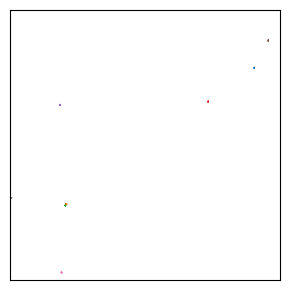

In [11]:
fig, ax = plt.subplots(figsize=(3, 3))

longest_tracks = void_tracks.sort_values('total_frames').tail(8)
for pos in longest_tracks['positions']:
    ax.scatter(pos[:, 0], pos[:, 1], s=1, edgecolor='none')

ax.set_xlim(0, 1024)
ax.set_ylim(0, 1024)
ax.set_xticks([])
ax.set_yticks([])
fig.tight_layout()
fig.savefig(out_directory / 'figures/collective-movement.png', dpi=320)

There doesn't seem to be a lot of drift, but it is colleated

In [12]:
corrected_tracks = initial_tracks.copy()
corrected_tracks['x'] -= total_drift[initial_tracks['frame'], 0]
corrected_tracks['y'] -= total_drift[initial_tracks['frame'], 1]
void_tracks = compile_void_tracks(corrected_tracks)
void_tracks.sort_values('total_frames').tail(2)

,start_frame,end_frame,total_frames,inferred_frames,positions,local_id,disp_from_start,max_disp,drift_rate,dist_traveled,total_traveled,movement_rate,radii,max_radius,min_radius,growth_rate
0,0,12,13,9,"[[196.0790273556, 28.0775075988], [195.9933130...","[0, None, None, None, 0, None, None, 0, None, ...","[0.0, 0.31427036384815316, 0.6285407276963106,...",2.795718,0.215055,"[0.0, 0.31427036384815316, 0.6285407276963106,...",9.377142,0.721319,"[14.4723151261, 14.59930368175, 14.7262922374,...",15.201743,14.295277,0.023396
5087,368,381,14,9,"[[5.926551936156561, 317.35569461432624], [6.2...","[7, None, None, 3, None, 5, None, None, None, ...","[0.0, 1.1207101966849622, 2.241420393369979, 3...",3.362131,0.240152,"[0.0, 1.1207101966849622, 2.241420393369979, 3...",4.526519,0.323323,"[6.3078313051, 6.924018934, 7.5402065629, 8.15...",9.097284,6.307831,0.232961


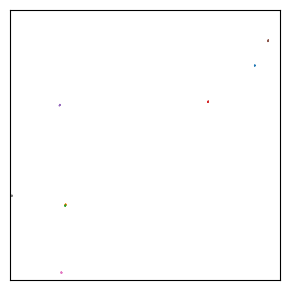

In [13]:
fig, ax = plt.subplots(figsize=(3, 3))

longest_tracks = void_tracks.sort_values('total_frames').tail(8)
for pos in longest_tracks['positions']:
    ax.scatter(pos[:, 0], pos[:, 1], s=1, edgecolor='none')

ax.set_xlim(0, 1024)
ax.set_ylim(0, 1024)
ax.set_xticks([])
ax.set_yticks([])
fig.tight_layout()
fig.savefig(out_directory / 'figures/subtracted-off-movement.png', dpi=320)

Plot the drift between frames 0 and 20

In [14]:
frame_1, frame_2 = 100, 150

In [15]:
image_1 = imageio.read(images[frame_1]).get_data(0)
image_2 = imageio.read(images[frame_2]).get_data(0)

In [16]:
drift = total_drift[frame_2, :] - total_drift[frame_1, :]
drift

array([5.54499364, 4.0637579 ])

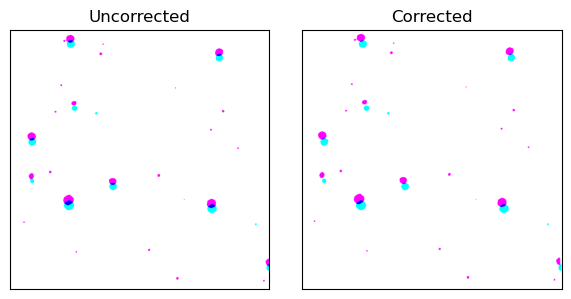

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(6, 3),)

for ax in axs:
    ax.set_yticks(ax.set_xticks([]))

# Plot the original and new overlapped
image = np.zeros((*image_1.shape, 3), dtype=np.uint8) + 255
image[:, :, 0] -= image_1
image[:, :, 1] -= image_2
axs[0].imshow(image)
axs[0].set_title('Uncorrected')

# Plot the re-registered images
affine = AffineTransform(translation=drift)
image_2_shift = np.array(warp(image_2, affine) * 255, dtype=np.uint8)
image = np.zeros((*image_1.shape, 3), dtype=np.uint8) + 255
image[:, :, 0] -= image_1
image[:, :, 1] -= image_2_shift
axs[1].imshow(image)
axs[1].set_title('Corrected')

fig.tight_layout()
fig.savefig(out_directory / 'figures/drift-correlation-tracks.png', dpi=320)

## Save for later use
Save the drifts and the defect coordinates

In [18]:
out_path = out_directory / 'drifts-tracks.csv'
pd.DataFrame(total_drift, columns=['x', 'y']).to_csv(out_path, index_label='frame')

Update the coordinates too

In [19]:
frame_data['positions_corrected-track'] = [(x - y) if len(x) > 0 else x for x, y in zip(frame_data['positions'], total_drift)]
frame_data['drift'] = total_drift.tolist()

In [20]:
frame_data.to_json(out_directory / 'defect-details.json', orient='records', lines=True)